# System identification with Neural Networks
## Mohammad Qori Aziz Hakiki - 23222020

Based on Tarek A. Tutunji (2016) - Parametric system identification using neural networks

### 1. Import library

In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import OrderedDict


### 2. Import Dataset From TXT

In [2]:
dataset = np.genfromtxt('6.txt',delimiter=';')
print(dataset)

# Get first column as input, skipping the header
input_tensor=torch.as_tensor(dataset[1:, 0], dtype=torch.float32)
input_tensor = torch.reshape(input_tensor, (len(input_tensor), 1))
# Get second column as output, skipping the header
output_tensor=torch.as_tensor(dataset[1:, 1], dtype=torch.float32)
output_tensor = torch.reshape(output_tensor, (len(output_tensor), 1))
input_tensor = input_tensor / 10
output_tensor = output_tensor / 200
print(input_tensor)
print(output_tensor)

[[      nan       nan       nan       nan]
 [ 5.        0.        0.        5.      ]
 [ 5.        1.06069  16.713107  5.      ]
 ...
 [ 0.        1.161356  0.        0.      ]
 [ 0.        1.010358  0.        0.      ]
 [ 0.        1.010358  0.        0.      ]]
tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])
tensor([[0.0000],
        [0.0053],
        [0.0556],
        ...,
        [0.0058],
        [0.0051],
        [0.0051]])


### 3. Define and Apply Time Delay Block to datasets

Here we apply time delay to our data. Suppose we predict that our DC motor transfer function will be like this:

$$H(z) = \frac{Y(z)}{U(z)} = \frac{b_{0} + b_{1}z^{-1}}{1 - a_{1}z^{-1} - a_{2}z^{-2}}$$

In time-domain, 

$$y(k) =a_{1}y(k-1) + a_{2}y(k-2) + b_{0}u(k) + b_{1}u(k-1)$$

Based on the reference paper, we will estimate the $a_{i}$ and $b_{j}$ parameter from the weight of the NN.  

To do so, the neural network inputs will be the delayed target output and inputs, in our case $y(k-1), y(k-2), u(k),$ and $u(k-1)$.


In [3]:
def timedelayblock(input, target, inp_order, target_order):
    delayed_nn_input = input

    # Append delayed input
    for i in range(1, inp_order+1):
        concated_tensor =torch.roll(input, i, 0)
        for j in range(i):
            concated_tensor[j, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    
    # Append delayed input
    for k in range(1, target_order+1):
        concated_tensor = torch.roll(target, k, 0)
        for l in range(k):
            concated_tensor[l, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    return delayed_nn_input
inp_order = 1
out_order = 2
# Create x(k), x(k-1), y(k-1), and y(k-2)
nn_input= timedelayblock(input_tensor, output_tensor, inp_order, out_order)
print(nn_input[0:5, :])
print(nn_input.size())

tensor([[0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0053, 0.0000],
        [0.5000, 0.5000, 0.0556, 0.0053],
        [0.5000, 0.5000, 0.1188, 0.0556]])
torch.Size([12473, 4])


In [4]:
# Split training and test data
nn_input_train = nn_input[:10000, :]
nn_input_test = nn_input[10000:, :]

y_train =output_tensor[:10000, :]
y_test = output_tensor[10000:, :]

### 4. Define NN Class

Define the NN model that will be used.  
Here we will add hidden layer and act function based on the parameters provided.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_dim, hidden_layer, out_classes):
        super(NeuralNetwork, self).__init__()
        # Create ordered Dictionary based on the number of hidden_layer
        sequence = OrderedDict()
        for layer in range(hidden_layer):
            if layer == 0:
                sequence['hidden_layer_{}'.format(layer)] =nn.Linear(
                    in_features, hidden_dim, bias=False)
                sequence['activation_{}'.format(layer)] =  nn.Tanh()
                continue
            # For layer not in the input layer
            sequence['hidden_layer_{}'.format(layer)] = nn.Linear(
                hidden_dim, hidden_dim, bias=False)
            sequence['activation_{}'.format(layer)] = nn.Tanh()
        # Insert output layer
        sequence['output_layer'] = nn.Linear(hidden_dim, out_classes, bias=False)

        # print(sequence)
        # return the sequential model
        self.layer_stack = nn.Sequential(sequence)
        

    def forward(self, x):
        x = self.layer_stack(x)
        return x


In [6]:
# Variable declaration
# Since we have u(k), u(k-1), y(k-1), and y(k-2), we have 4 inputs.

in_features=inp_order + out_order +1  # how many Variables are in the dataset
hidden_dim= inp_order + out_order +1 # hidden i/o
hidden_layer=3 # how many hidden layers
output_dim=1   # number of classes
epoch = 50

In [7]:
clf=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(clf)

params = clf.parameters()
# print(len(params))

for p in params:
    print(p.size())  # conv1's .weight
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.0647, -0.3393,  0.2054, -0.0820],
        [ 0.4613, -0.3248,  0.2080, -0.2496],
        [-0.2473,  0.1452,  0.4052, -0.1225],
        [-0.3723, -0.0373, -0.3916,  0.3571]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.3405,  0.2364,  0.1971, -0.4974],
        [-0.2870, -0.2716,  0.2508, -0.3347],
        [-0.1421,  0.1840, -0.0509, -0.2530],
        [-0.4546,  0.4666,  0.3337, -0.4095]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.0058,  0.0974,  0.0545, -0.3256],
    

### 5. Compute weight and biases of our networks

In [8]:
# Test our networks
out = clf(nn_input_train)
print(out)

tensor([[-0.0017],
        [ 0.0125],
        [ 0.0127],
        ...,
        [ 0.0102],
        [ 0.0101],
        [ 0.0104]], grad_fn=<MmBackward0>)


In [9]:
# Construct loss function for learning
criterion = nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(clf.parameters(), lr = 0.3)

In [10]:
for e in range(epoch):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = clf(nn_input_train)

   # Compute and print loss
   loss = criterion(y_pred, y_train)
   print('epoch: ', e,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.3436567485332489
epoch:  1  loss:  0.3227179944515228
epoch:  2  loss:  0.29383522272109985
epoch:  3  loss:  0.25160232186317444
epoch:  4  loss:  0.1932978630065918
epoch:  5  loss:  0.12495879828929901
epoch:  6  loss:  0.06501361727714539
epoch:  7  loss:  0.030219538137316704
epoch:  8  loss:  0.01758217252790928
epoch:  9  loss:  0.014474591240286827
epoch:  10  loss:  0.013779614120721817
epoch:  11  loss:  0.013521737419068813
epoch:  12  loss:  0.01333241444081068
epoch:  13  loss:  0.013155564665794373
epoch:  14  loss:  0.01298342552036047
epoch:  15  loss:  0.012814928777515888
epoch:  16  loss:  0.01264986302703619
epoch:  17  loss:  0.01248811837285757
epoch:  18  loss:  0.012329600751399994
epoch:  19  loss:  0.01217421144247055
epoch:  20  loss:  0.012021856382489204
epoch:  21  loss:  0.011872446164488792
epoch:  22  loss:  0.0117258932441473
epoch:  23  loss:  0.011582107283174992
epoch:  24  loss:  0.011441008187830448
epoch:  25  loss:  0.0113025

In [11]:
for param in clf.parameters():
   print(param)

# Loss testing
y_pred_test = clf(nn_input_test)
print(y_pred_test)
loss = criterion(y_pred_test, y_test)
print(' loss: ', loss.item())

Parameter containing:
tensor([[-0.1086, -0.3843,  0.0711, -0.2184],
        [ 0.4775, -0.3080,  0.2784, -0.1779],
        [-0.2056,  0.1878,  0.5199, -0.0062],
        [-0.3967, -0.0630, -0.5104,  0.2359]], requires_grad=True)
Parameter containing:
tensor([[-0.3873,  0.2528,  0.2789, -0.5715],
        [-0.3159, -0.2612,  0.2920, -0.3784],
        [-0.0981,  0.1700, -0.1028, -0.1855],
        [-0.4837,  0.4770,  0.3919, -0.4569]], requires_grad=True)
Parameter containing:
tensor([[-0.2144, -0.0594, -0.0043, -0.5518],
        [ 0.3412, -0.5011,  0.4199,  0.2425],
        [-0.6601, -0.2617,  0.1283, -0.3325],
        [-0.1420, -0.0861,  0.3052,  0.0339]], requires_grad=True)
Parameter containing:
tensor([[-0.5874,  0.0668, -0.9166,  0.0020]], requires_grad=True)
tensor([[0.3657],
        [0.3663],
        [0.3550],
        ...,
        [0.0036],
        [0.0037],
        [0.0031]], grad_fn=<MmBackward0>)
 loss:  0.002844685222953558


tensor([[0.3657],
        [0.3663],
        [0.3550],
        ...,
        [0.0036],
        [0.0037],
        [0.0031]], grad_fn=<MmBackward0>)


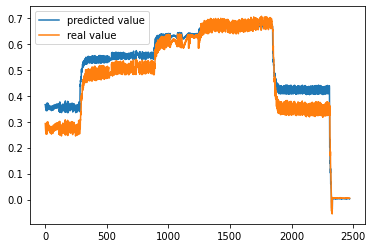

In [12]:
import matplotlib.pyplot as plt
nn_input_test = nn_input_test.detach().numpy()

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

In [13]:
# Check weight
params = clf.named_parameters()

for p in params:
    print(p)

('layer_stack.hidden_layer_0.weight', Parameter containing:
tensor([[-0.1086, -0.3843,  0.0711, -0.2184],
        [ 0.4775, -0.3080,  0.2784, -0.1779],
        [-0.2056,  0.1878,  0.5199, -0.0062],
        [-0.3967, -0.0630, -0.5104,  0.2359]], requires_grad=True))
('layer_stack.hidden_layer_1.weight', Parameter containing:
tensor([[-0.3873,  0.2528,  0.2789, -0.5715],
        [-0.3159, -0.2612,  0.2920, -0.3784],
        [-0.0981,  0.1700, -0.1028, -0.1855],
        [-0.4837,  0.4770,  0.3919, -0.4569]], requires_grad=True))
('layer_stack.hidden_layer_2.weight', Parameter containing:
tensor([[-0.2144, -0.0594, -0.0043, -0.5518],
        [ 0.3412, -0.5011,  0.4199,  0.2425],
        [-0.6601, -0.2617,  0.1283, -0.3325],
        [-0.1420, -0.0861,  0.3052,  0.0339]], requires_grad=True))
('layer_stack.output_layer.weight', Parameter containing:
tensor([[-0.5874,  0.0668, -0.9166,  0.0020]], requires_grad=True))


### 6. Transform NN Weights to Transfer Function

In here, we define an NN2TF algorithm. Based on the reference paper, the parameter $a_{j}$ and $b_{i}$ can be estimated by

$$a_{j} = (\sum_{h=1}^H (wout_{h}v_{jh}))$$

$$b_{i} = (\sum_{h=1}^H (wout_{h}w_{ih}))$$

For tanh activation function.

In [14]:
def nn2tf(nn, hidden_layer, inp_order, target_order):
    regressor = np.zeros((1, inp_order+target_order+1))
    wout = nn.state_dict()['layer_stack.output_layer.weight']
    wout = wout.numpy()
    print('wout : ', wout)
    # print(wout.size())
    params = nn.named_parameters()
    i = 0
    for p in params:
        # print(p)

        w_hidden = nn.state_dict()['layer_stack.hidden_layer_{}.weight'.format(i)]
        w_hidden = w_hidden.numpy()
        print('w_hidden : ', w_hidden)
        # Update regressor
        regressor = regressor + (wout @ w_hidden)
        print(regressor)

        i = i + 1
        if i == hidden_layer :
            break
    
    # regressor = regressor * 0.5
    return regressor


regressor = nn2tf(clf, hidden_layer, inp_order, out_order)
print(regressor)

wout :  [[-0.5874373   0.06680959 -0.9165841   0.00204469]]
w_hidden :  [[-0.10864643 -0.38427192  0.07108258 -0.2184248 ]
 [ 0.47747523 -0.3079632   0.27836332 -0.17790885]
 [-0.20560056  0.18782023  0.5198529  -0.00622337]
 [-0.39668718 -0.0629587  -0.51039565  0.23590182]]
[[ 0.283362    0.03287899 -0.50069165  0.12261144]]
w_hidden :  [[-0.3872982   0.2527757   0.27890188 -0.57147574]
 [-0.31588036 -0.2611922   0.29196066 -0.37836635]
 [-0.0980856   0.16999206 -0.10280375 -0.18552156]
 [-0.48368025  0.47699633  0.39194185 -0.45686242]]
[[ 0.5786863  -0.28789774 -0.54999356  0.60215107]]
w_hidden :  [[-0.21437968 -0.05936877 -0.00425621 -0.5517664 ]
 [ 0.3411578  -0.5011469   0.41986987  0.24249107]
 [-0.66013503 -0.2616522   0.12825373 -0.33246005]
 [-0.1420457  -0.08606097  0.3051826   0.03388837]]
[[ 1.33219236 -0.04685347 -0.6363733   1.24727682]]
[[ 1.33219236 -0.04685347 -0.6363733   1.24727682]]


In [15]:
# Stabilize pole, use if there are unstable pole

# for i in range(inp_order + 1, len(regressor[0])):
#     print(i)
#     while abs(regressor[0][i]) > 1:
#         regressor[0][i]= regressor[0][i] * 0.9
#         # print(regressor[0][i])
#         print(regressor)


In [16]:
# Calculate estimated output from our model
y_pred = np.zeros((len(output_tensor),1))

nn_input_detach = nn_input.detach().numpy()

for i in range(len(output_tensor)):
    for j in range (len(regressor)):
        y_pred[i] += regressor[0][j] * nn_input_detach[i][j]
   

[[0.66609618]
 [0.66609618]
 [0.66609618]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


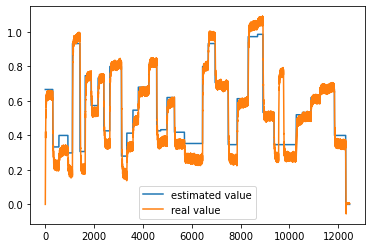

In [17]:
# Plot estimated output

print(y_pred)
plt.plot(y_pred, label='estimated value')
plt.plot(output_tensor, label='real value')
leg = plt.legend()
